In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#### The input is a 2D coordinate 
#### The target output is 1 if the point lies inside a circle of radius equal to 1
#### r=1 centered at the origin, and 0 otherwise.

In [4]:
# Generate synthetic data: points inside and outside a circle
np.random.seed(42)
num_points = 1000
X = np.random.uniform(-1.5, 1.5, (num_points, 2))  # Random points in a 2D space
y = (X[:, 0]**2 + X[:, 1]**2 <= 1).astype(float).reshape(-1, 1)  # 1 if inside the circle, 0 otherwise

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [6]:
# Add non-linear features (x1^2 + x2^2)
X_transformed = torch.cat([X, (X[:, 0]**2 + X[:, 1]**2).unsqueeze(1)], dim=1)

# Define the model
class SimplePerceptronWithFeatures(nn.Module):
    def __init__(self):
        super(SimplePerceptronWithFeatures, self).__init__()
        self.fc = nn.Linear(3, 1)  # 3 input features (x1, x2, x1^2 + x2^2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = SimplePerceptronWithFeatures()

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_transformed)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.1043
Epoch [200/1000], Loss: 0.0711
Epoch [300/1000], Loss: 0.0568
Epoch [400/1000], Loss: 0.0484
Epoch [500/1000], Loss: 0.0427
Epoch [600/1000], Loss: 0.0385
Epoch [700/1000], Loss: 0.0353
Epoch [800/1000], Loss: 0.0327
Epoch [900/1000], Loss: 0.0305
Epoch [1000/1000], Loss: 0.0287


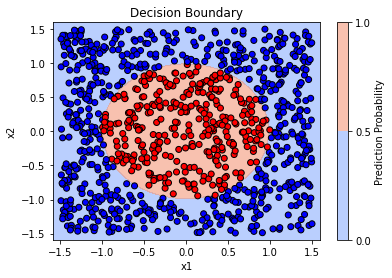

In [7]:
def plot_decision_boundary_with_features(model, X, y):
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Add the non-linear feature (x1^2 + x2^2)
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_with_feature = np.c_[grid, (grid[:, 0]**2 + grid[:, 1]**2)]  # Add x1^2 + x2^2

    # Convert to PyTorch tensor
    grid_tensor = torch.tensor(grid_with_feature, dtype=torch.float32)

    # Predict on the grid
    with torch.no_grad():
        preds = model(grid_tensor).reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], alpha=0.6, cmap="coolwarm")
    plt.colorbar(label="Prediction Probability")

    # Plot the input data points
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap="bwr", edgecolor="k")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision Boundary")
    plt.show()

# Call the function with transformed features
plot_decision_boundary_with_features(model, X.numpy(), y.numpy())